In [2]:
import pandas as pd
from skimage.color import rgb2gray
from skimage.measure import find_contours
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2 as cv2
import cv2 as cv
import skimage.io as io
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, skeletonize, thin
from skimage.filters import gaussian
from tempfile import TemporaryFile
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image
import PIL
import os
import glob
import threading
import time
import csv
%matplotlib inline


def resize(image, width=200, hsize=None):
    base_width = width
    width_percent = (base_width / float(image.size[0]))
    hsize = int(
        (float(image.size[1]) * float(width_percent))) if hsize == None else hsize
    image = image.resize((base_width, hsize), PIL.Image.ANTIALIAS)
    return image


def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    #     their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


def show_histo(img):
    dst = cv2.calcHist(img, [0], None, [256], [0, 256])
    plt.hist(img.ravel(), 256, [0, 256])
    plt.title('Histogram for gray scale image')
    plt.show()


def get_result(img, mask):
    copy = img.copy()
    channels = img.shape[2]
    for i in range(channels):
        copy[:, :, i] = np.bitwise_and(copy[:, :, i], mask)
    temp = mask.copy()
    temp[mask == 0] = 255
    temp[mask == 255] = 0
    for i in range(channels):
        copy[:, :, i] = np.bitwise_or(copy[:, :, i], temp)
    return copy


def shadow_remove(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(
            diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremov = cv2.merge(result_norm_planes)
    return shadowremov


def reduce_image(img, thickness):
    mask1 = img.copy()
    mask1[:thickness, :] = 0
    mask1[-1*thickness:, :] = 0
    mask1[:, :thickness] = 0
    mask1[:, -1*thickness:] = 0
    return mask1


def get_binary_low_medium_constract(img_RGB):
    gray = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    # ret, img_binary_gray = cv2.threshold(
    #     gray, 125, 255, cv2.THRESH_BINARY)
    # show_images([gray, img_binary_gray])
    img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    ret, img_binary = cv2.threshold(
        img_HSV[:, :, 1], 50, 255, cv2.THRESH_BINARY)
    ret, img_binary2 = cv2.threshold(
        img_HSV[:, :, 2], 50, 255, cv2.THRESH_BINARY)
    img_binary[img_binary2 == 0] = 0
    # img_binary[img_binary_gray == 255] = 255
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # Apply erosion to the image
    erode_img = cv2.erode(img_binary, kernel, iterations=2)
    dilate_img = cv2.dilate(erode_img, kernel, iterations=2)
    return dilate_img


def get_binary_heigh_constract(img_RGB):
    # img_RGBA = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2RGBA)
    # img_gray = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    # ret, img_binary = cv2.threshold(img_gray, 60, 255, cv2.THRESH_BINARY_INV)
    # img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    # img_YCC = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCR_CB)
    # img_BGR = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2BGR)
    img_YUV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YUV)

    # Make float and divide by 255 to give BGRdash
    # bgrdash = img_BGR.astype(np.float)/255.

    # hls_img = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HLS)
    # lab_img = cv.cvtColor(img_RGB, cv.COLOR_RGB2LAB)

    # img_HSV[:, :, 0] = cv2.equalizeHist(img_HSV[:, :, 0])
    # img_HSV[:, :, 1] = cv2.equalizeHist(img_HSV[:, :, 1])
    # img_HSV[:, :, 2] = cv2.equalizeHist(img_HSV[:, :, 2])

    # img_YCC[:, :, 0] = cv2.equalizeHist(img_YCC[:, :, 0])
    # img_YCC[:, :, 1] = cv2.equalizeHist(img_YCC[:, :, 1])
    # img_YCC[:, :, 2] = cv2.equalizeHist(img_YCC[:, :, 2])

#     img_YUV[:, :, 0] = cv2.equalizeHist(img_YUV[:, :, 0])
#     img_YUV[:, :, 1] = cv2.equalizeHist(img_YUV[:, :, 1])
    img_YUV[:, :, 2] = cv2.equalizeHist(img_YUV[:, :, 2])

    # hls_img[:, :, 0] = cv2.equalizeHist(hls_img[:, :, 0])
    # hls_img[:, :, 1] = cv2.equalizeHist(hls_img[:, :, 1])
    # hls_img[:, :, 2] = cv2.equalizeHist(hls_img[:, :, 2])

    # lab_img[:, :, 0] = cv2.equalizeHist(lab_img[:, :, 0])
    # lab_img[:, :, 1] = cv2.equalizeHist(lab_img[:, :, 1])
    # lab_img[:, :, 2] = cv2.equalizeHist(lab_img[:, :, 2])

    ret, img_binary1 = cv2.threshold(
        img_YUV[:, :, 2], 150, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilate_img = cv2.erode(img_binary1, kernel, iterations=1)
    erode_img = cv2.dilate(dilate_img, kernel, iterations=1)
    return erode_img


def calculate_brightness(gray, index=None):
    mean_value = cv2.mean(gray)[0]
    if index is not None:
        show_images([gray], [str(index)])
        print("the image "+str(index)+" has mean value : ", mean_value)
    return mean_value


def image_pre_processing(path):
    image = Image.open(path)
    image = resize(image, 4 * 128, 4 * 64)
    img_RGB = np.array(image)
    gray = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    mean_value = calculate_brightness(gray)
    dilate_img = None
    if (mean_value >= 190):
        dilate_img = get_binary_heigh_constract(img_RGB)
    else:
        dilate_img = get_binary_low_medium_constract(img_RGB)
    dilate_img[dilate_img == 255] = 1
    mask1 = dilate_img
    mask1[mask1 != 1] = 0
    mask1[mask1 == 1] = 255
    mask1 = reduce_image(img=mask1, thickness=3)

    blured = cv2.GaussianBlur(mask1, (5, 5), 0)
    edges = cv2.Canny(blured, threshold1=40, threshold2=100,
                      apertureSize=3, L2gradient=False)

    # Define the kernel for closing operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

    # Perform closing operation
    closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    # show_images([img_gray,edges,closed_edges],['img_gray','edges','closed_edges'])
    contours, hierarchy = cv2.findContours(
        closed_edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # print(len(contours))
    mask = np.zeros_like(edges)
    max_area = 0
    second_max = 0
    biggest_contour = None
    second_biggest = None
    for cnt in contours:
        #     mask=cv2.drawContours(mask, [cnt], -1, (255,255,255), -1)
        area = cv2.contourArea(cnt)
        if area > max_area:
            max_area = area
            biggest_contour = cnt
    if len(contours) > 0:
        mask = cv2.drawContours(
            mask, [biggest_contour], -1, (255, 255, 255), -1)
    result = get_result(img_RGB, mask)
    kernel = np.ones((5, 5), np.float32)/25
    result = cv.filter2D(result, -1, kernel)
    result = cv2.resize(result, (128, 64))
    result = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
    return mask, result


with open('true.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    with open('output.txt', 'w') as txtfile:
        for row in reader:
            if row: # check if row is not empty
                txtfile.write(row[0]+','+row[1] + '\n')



In [3]:
# Specify the path to your text file
file_path = 'output.txt'
liens=[]
# Open the text file
with open(file_path, 'r') as file:
    # Read the contents of the file
    for line in file:
        liens.append(line.split(','))
directory='./Dataset_new_filtered'
for line in liens:
    actuly=line[0][0]
    pretected=line[1]
    gender_path= 'men' if line[0][2]=='m' else 'women'
    number_path = line[0][0]
    image_name=line[0]
    path= directory + '/' + gender_path + '/' + number_path + '/' +image_name
#     print(line[0],line[1])
#     print(path)
#     binary, result = image_pre_processing(path)
    binary, result = image_pre_processing(path)
    image = Image.open(path)
    image = resize(image, 4 * 128, 4 * 64)
    img_RGB = np.array(image)
    
    show_images([img_RGB, binary, result], ['origenal', 'binary ', 'result'])
    print('actualy: ',actuly,' predected :',pretected)
    print(path)

FileNotFoundError: [Errno 2] No such file or directory: './test_set_1//women/2/2_woman (88).JPG'

C:\Users\Asus\AppData\Local\Temp\ipykernel_10652\640974663.py:31: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((base_width, hsize), PIL.Image.ANTIALIAS)


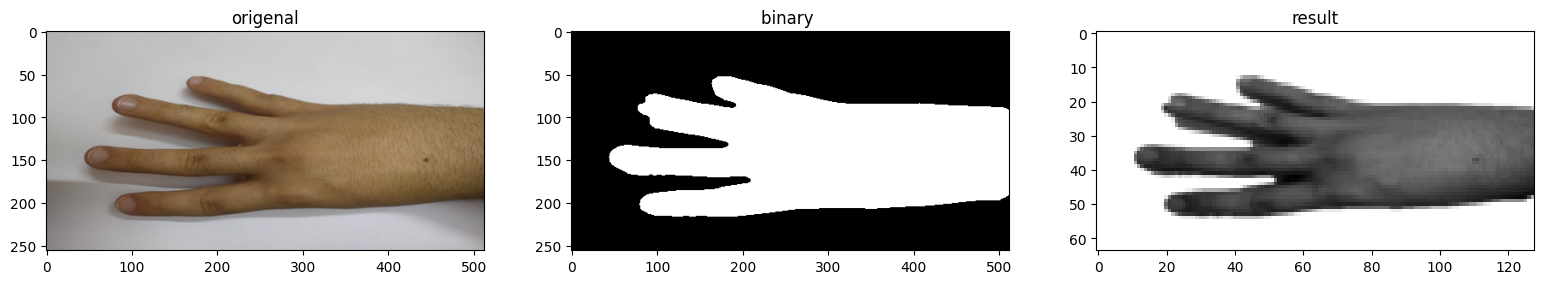

actualy:  2  predected : 1

./test_set_1/


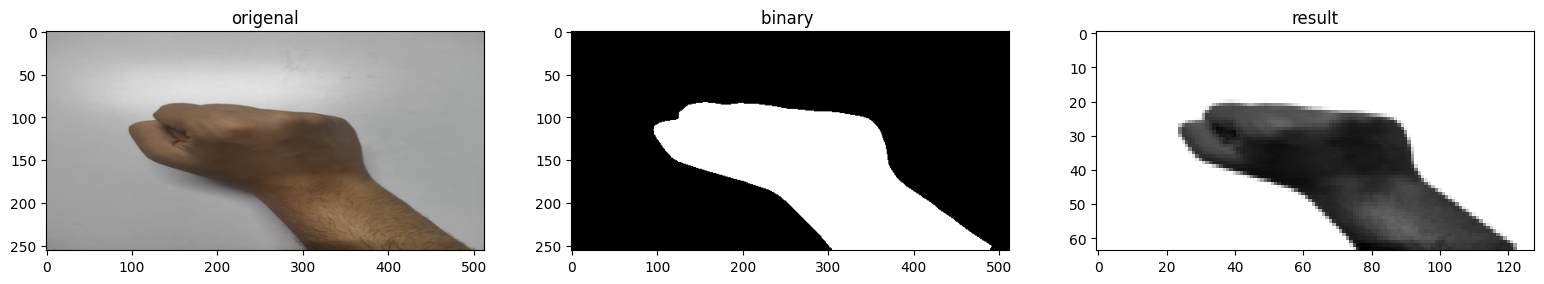

actualy:  2  predected : 1

./test_set_1/


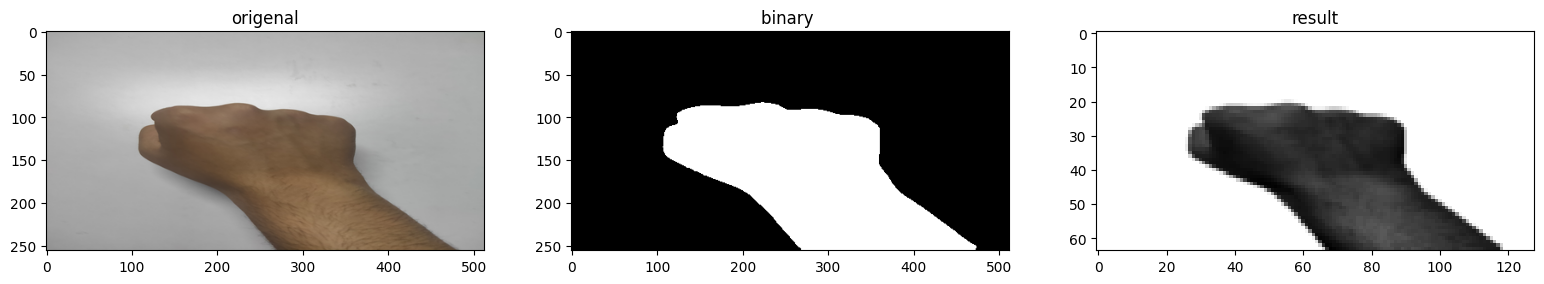

actualy:  2  predected : 1

./test_set_1/


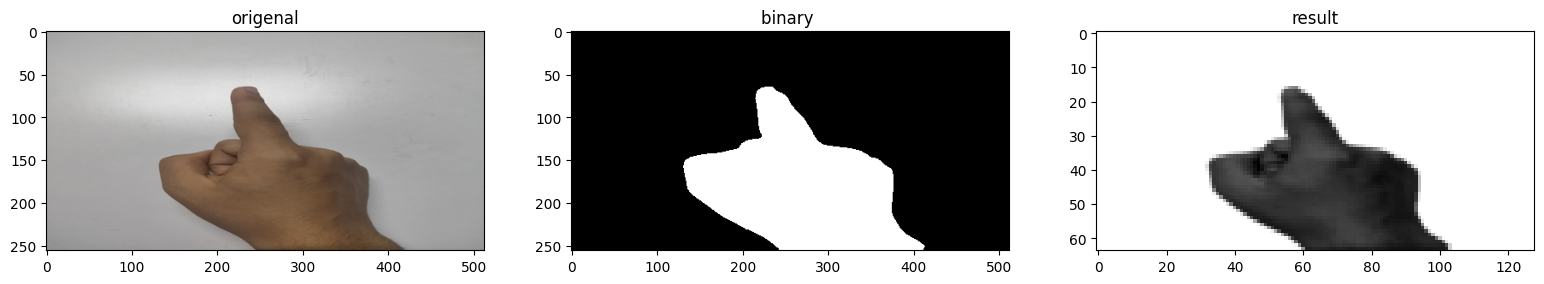

actualy:  2  predected : 1

./test_set_1/


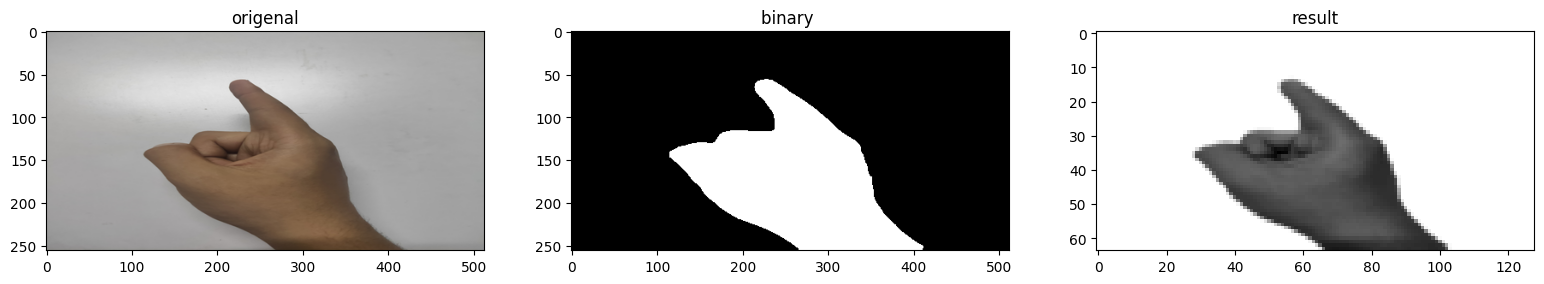

actualy:  2  predected : 1

./test_set_1/


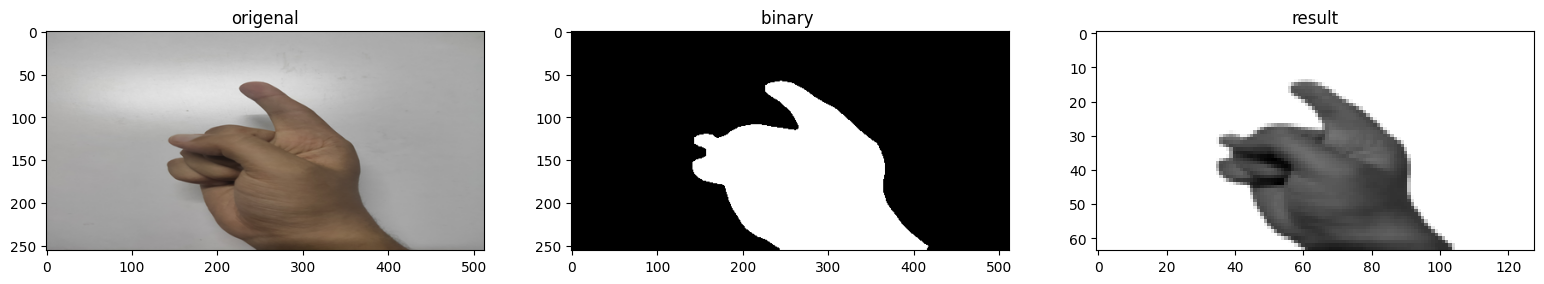

actualy:  2  predected : 1

./test_set_1/


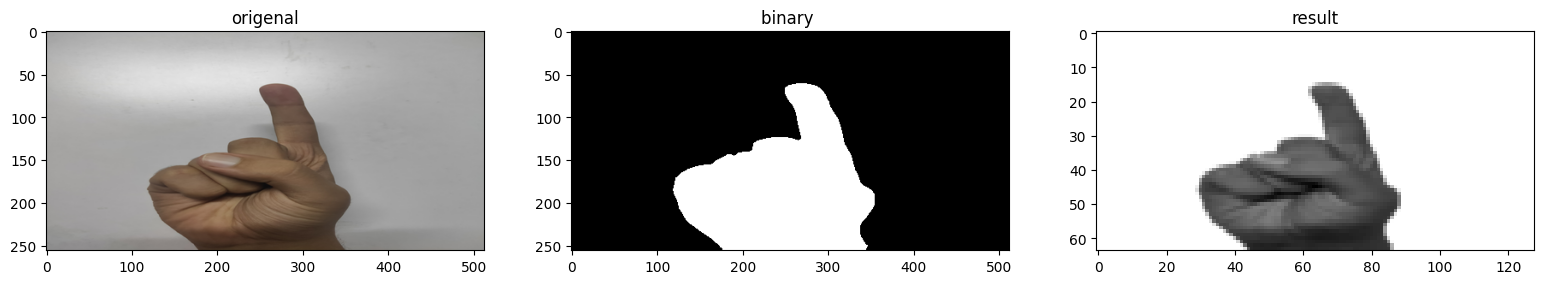

actualy:  2  predected : 1

./test_set_1/


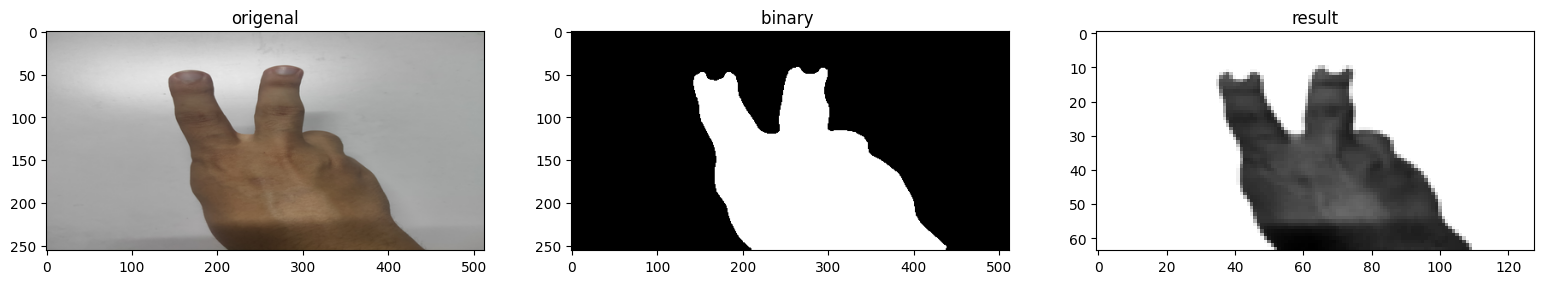

actualy:  2  predected : 1

./test_set_1/


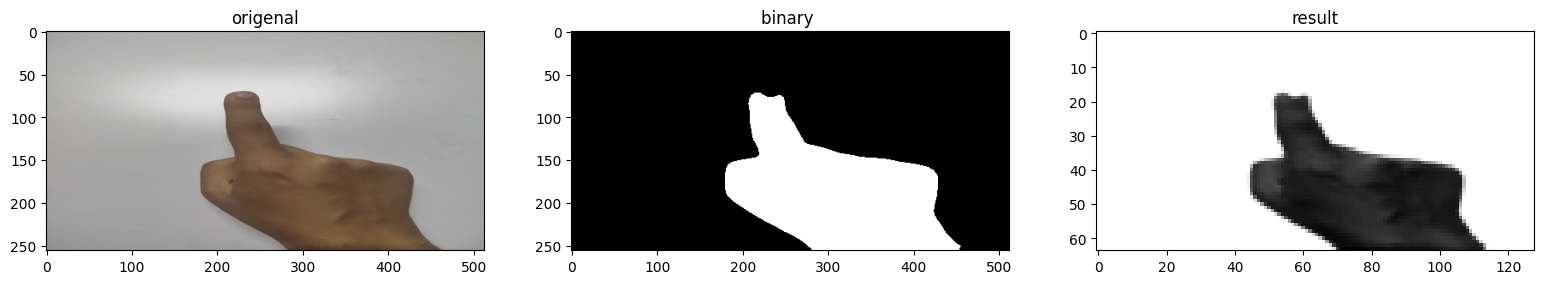

actualy:  2  predected : 1

./test_set_1/


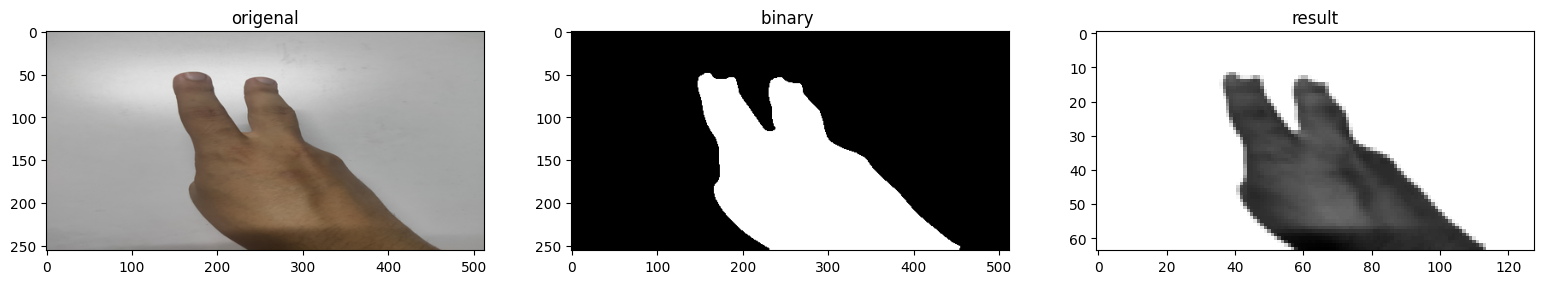

actualy:  2  predected : 1

./test_set_1/


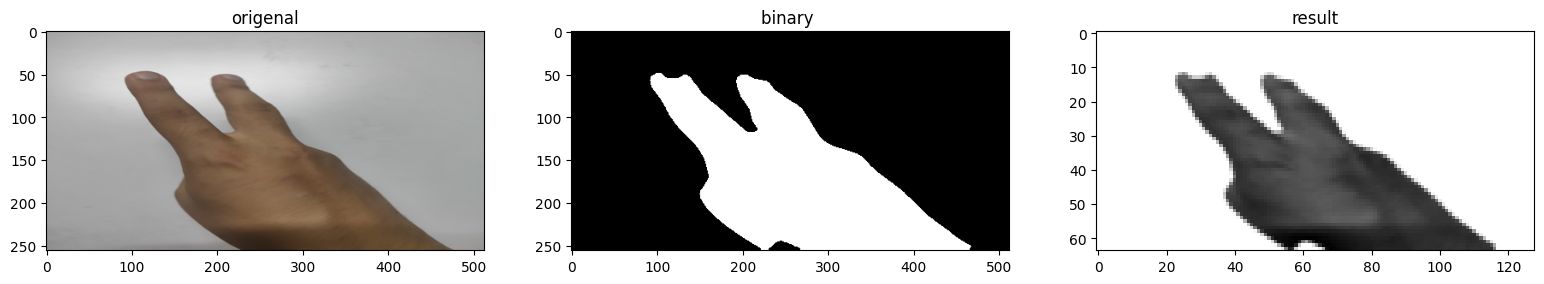

actualy:  2  predected : 1

./test_set_1/


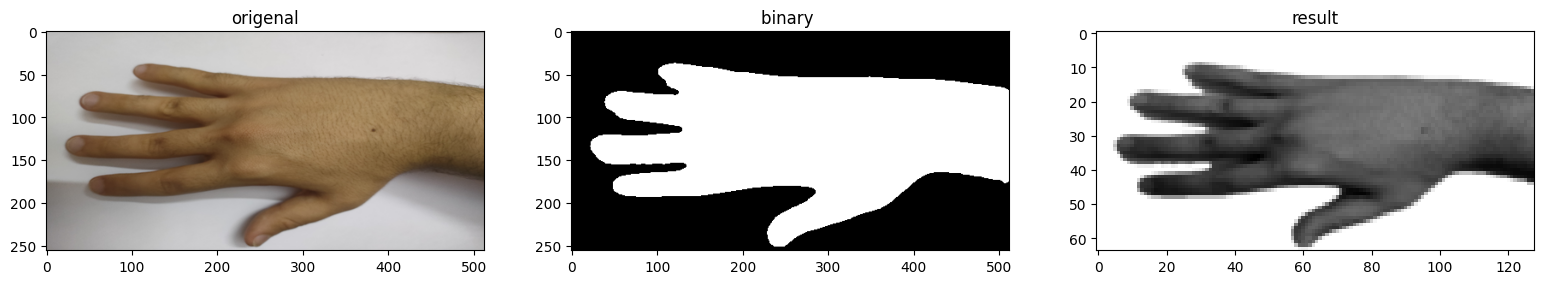

actualy:  2  predected : 1

./test_set_1/


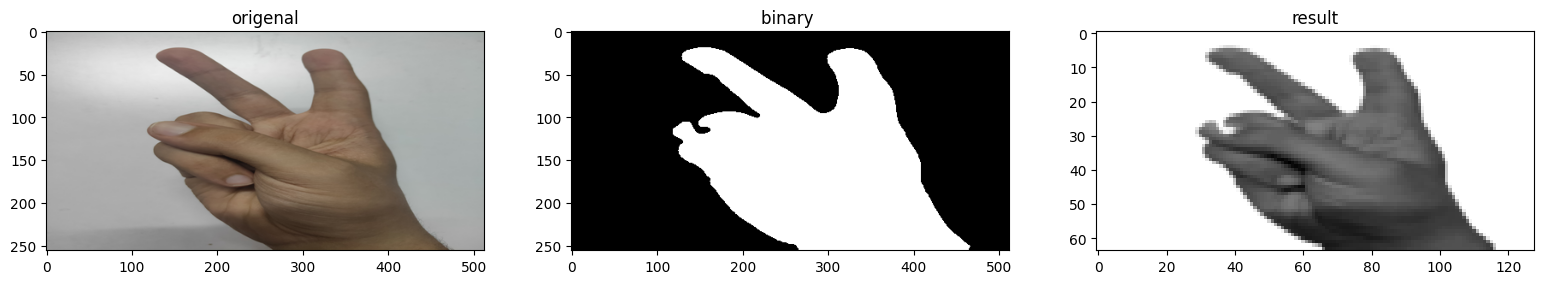

actualy:  2  predected : 1

./test_set_1/


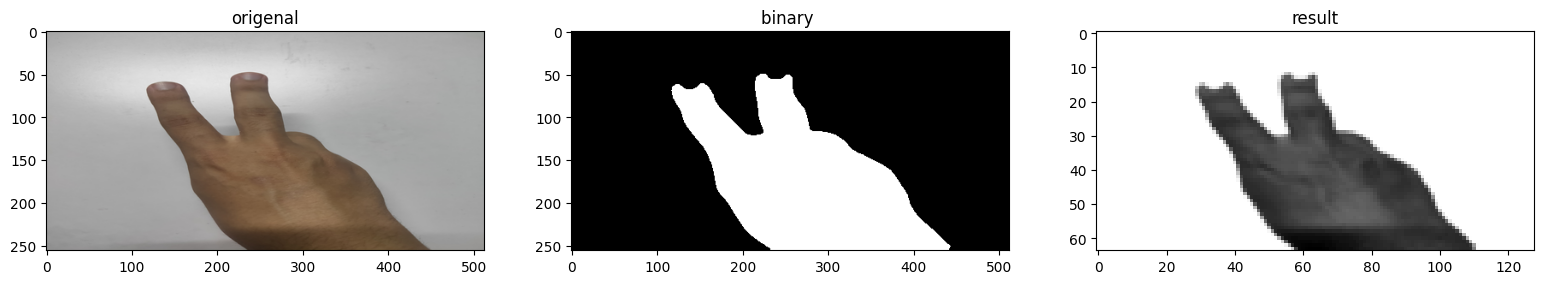

actualy:  2  predected : 1

./test_set_1/


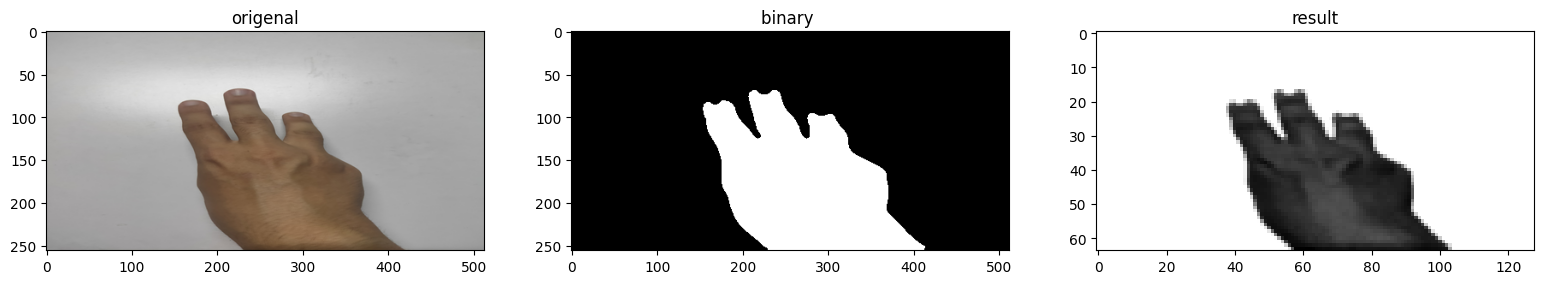

actualy:  2  predected : 1

./test_set_1/


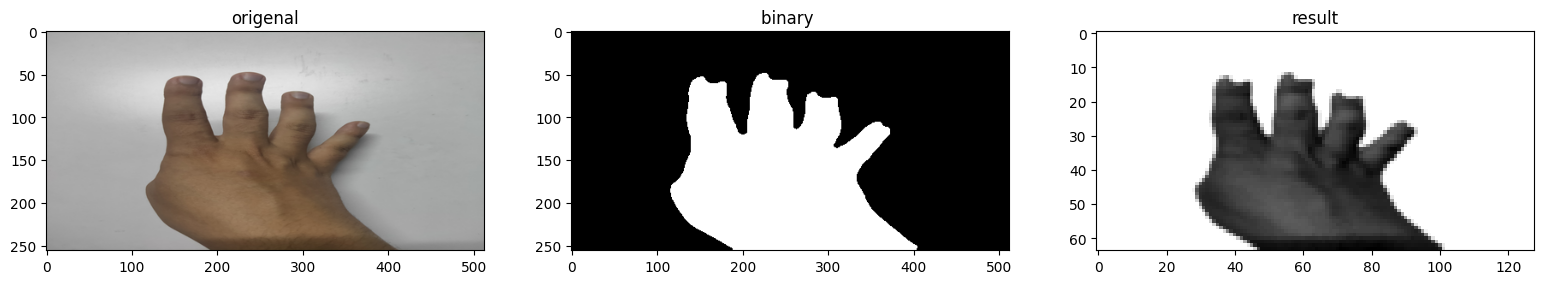

actualy:  2  predected : 1

./test_set_1/


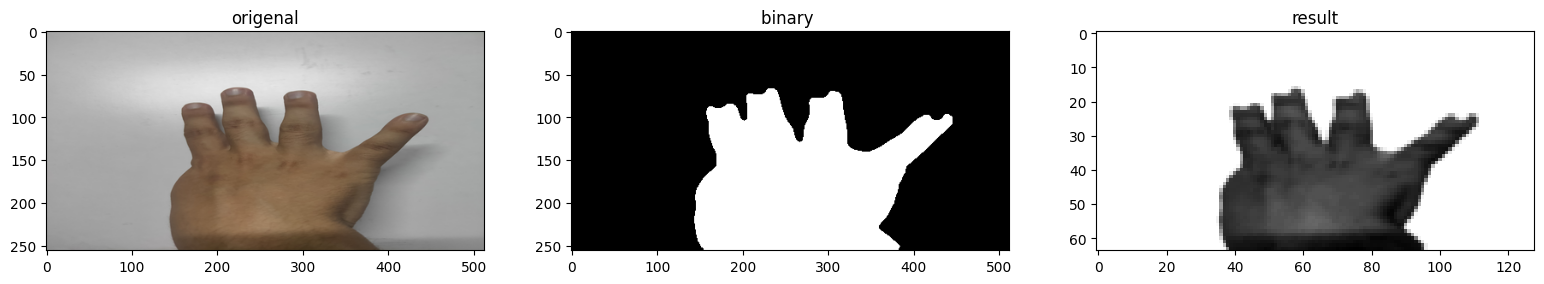

actualy:  2  predected : 1

./test_set_1/


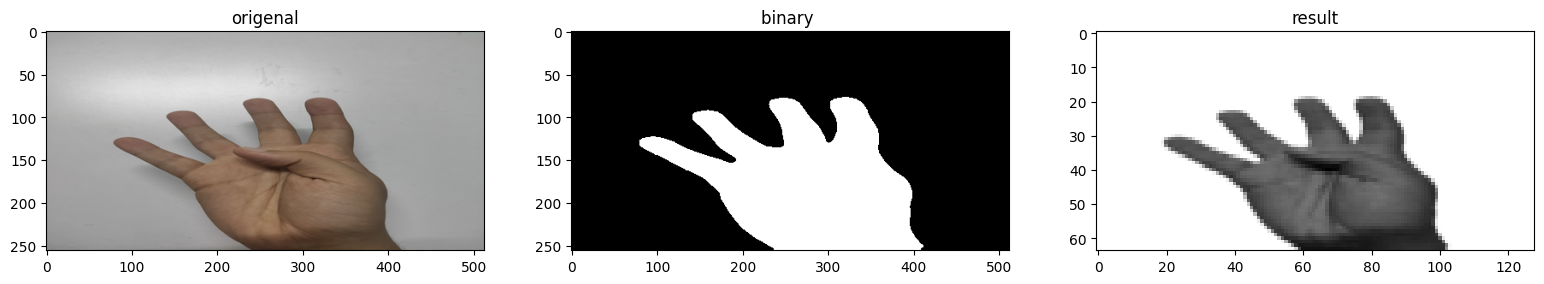

actualy:  2  predected : 1

./test_set_1/


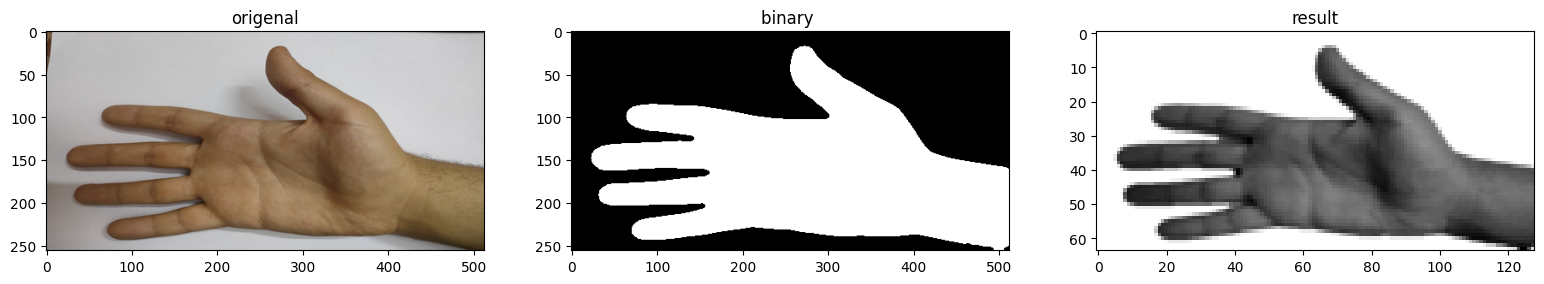

actualy:  2  predected : 1

./test_set_1/


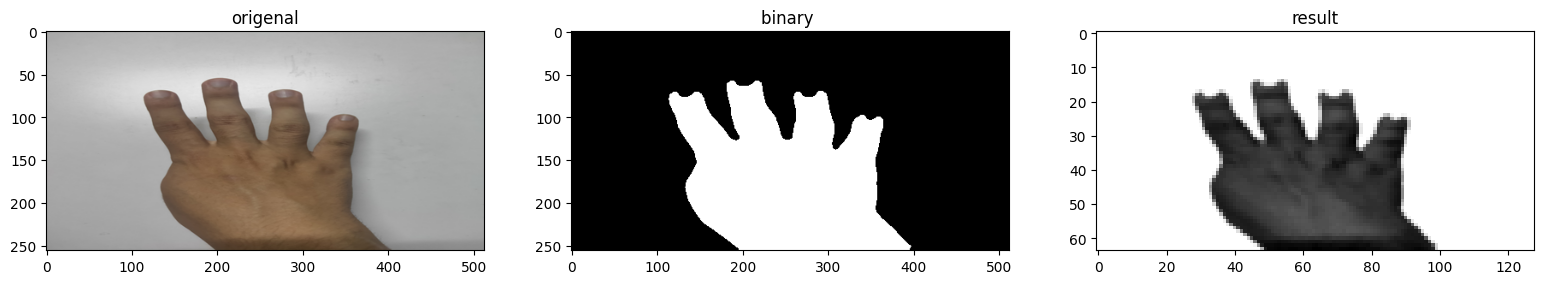

actualy:  2  predected : 1

./test_set_1/


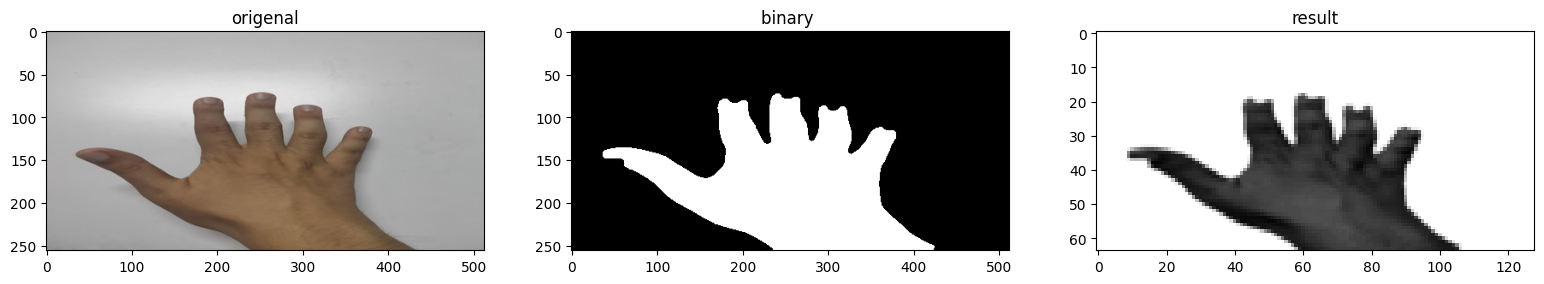

actualy:  2  predected : 1

./test_set_1/


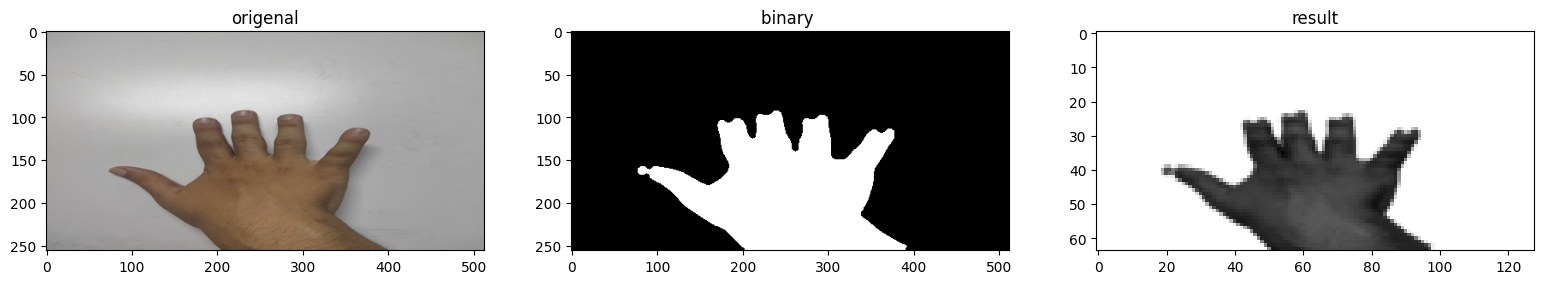

actualy:  2  predected : 1

./test_set_1/


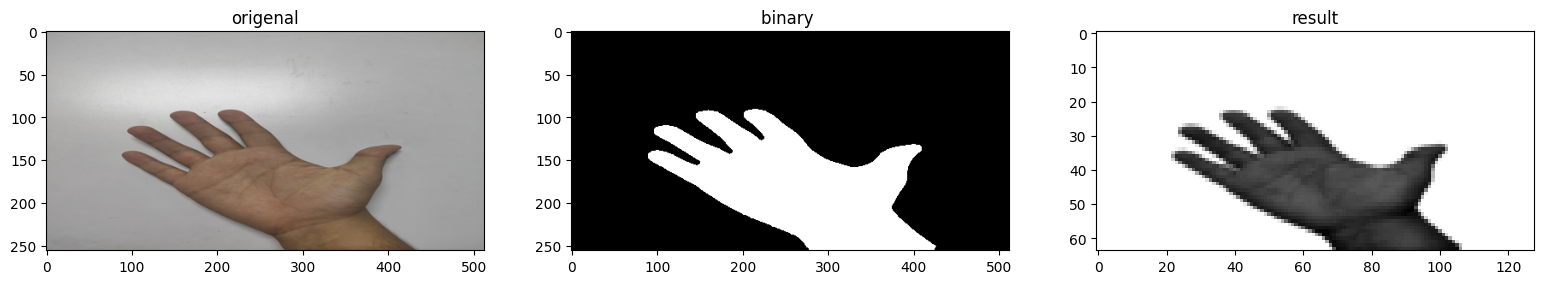

actualy:  2  predected : 1

./test_set_1/


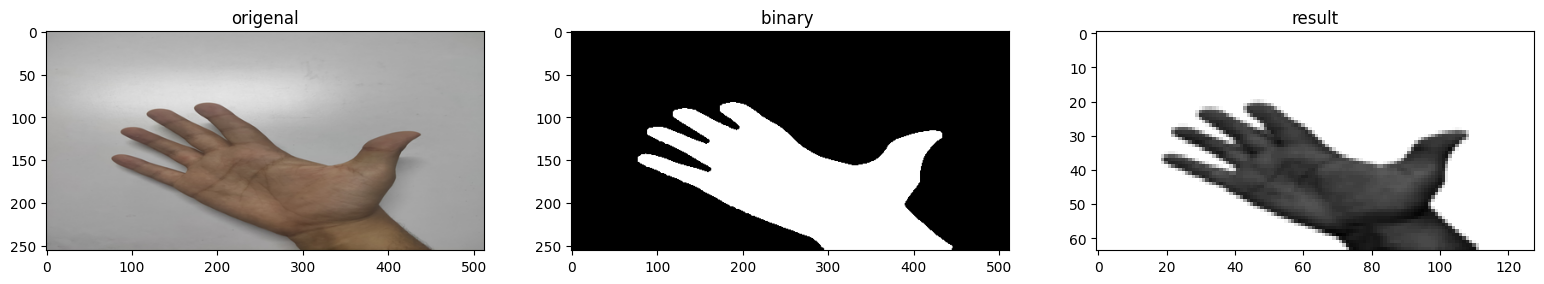

actualy:  2  predected : 1

./test_set_1/


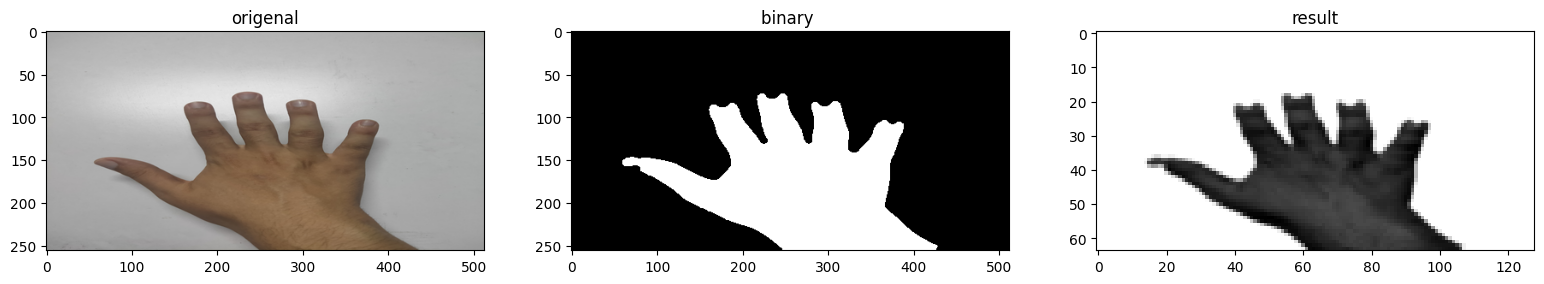

actualy:  2  predected : 1

./test_set_1/


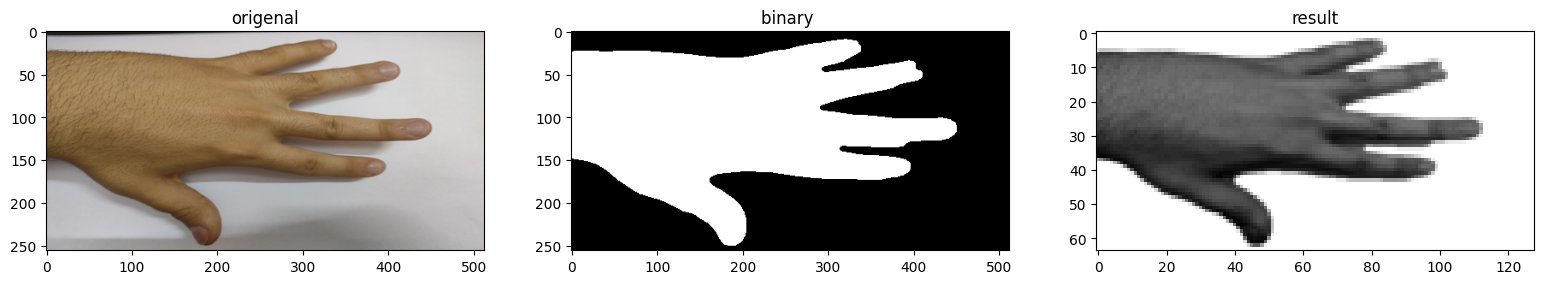

actualy:  2  predected : 1

./test_set_1/


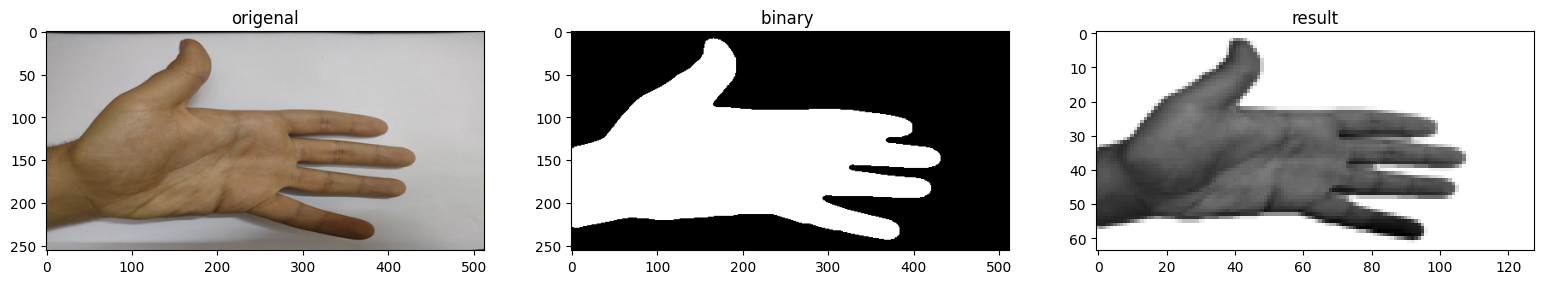

actualy:  2  predected : 1

./test_set_1/


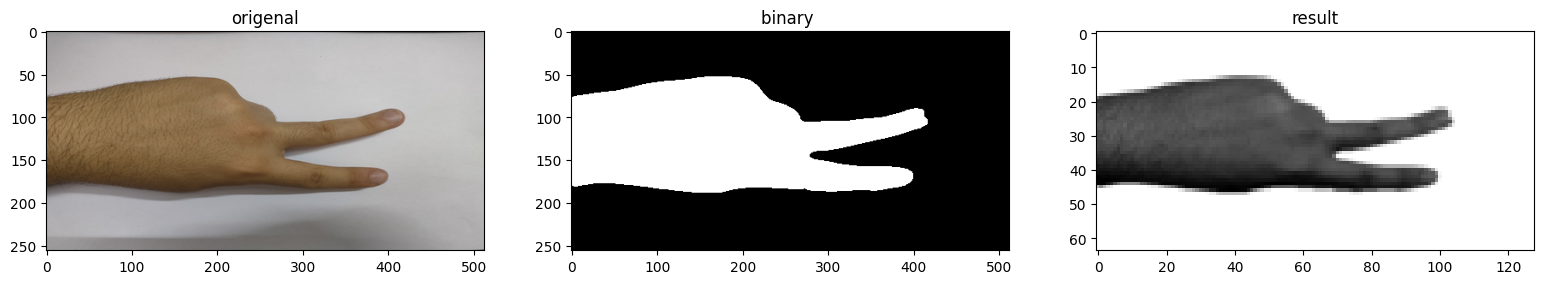

actualy:  2  predected : 1

./test_set_1/


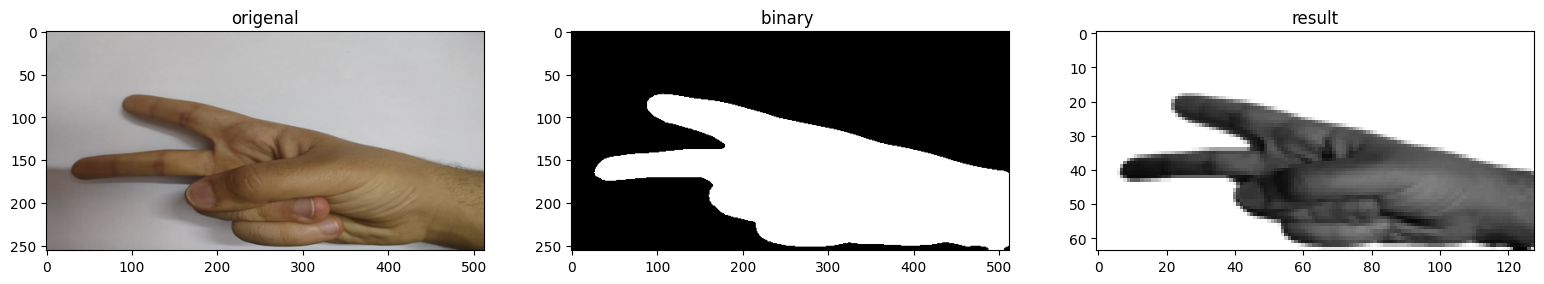

actualy:  2  predected : 1

./test_set_1/


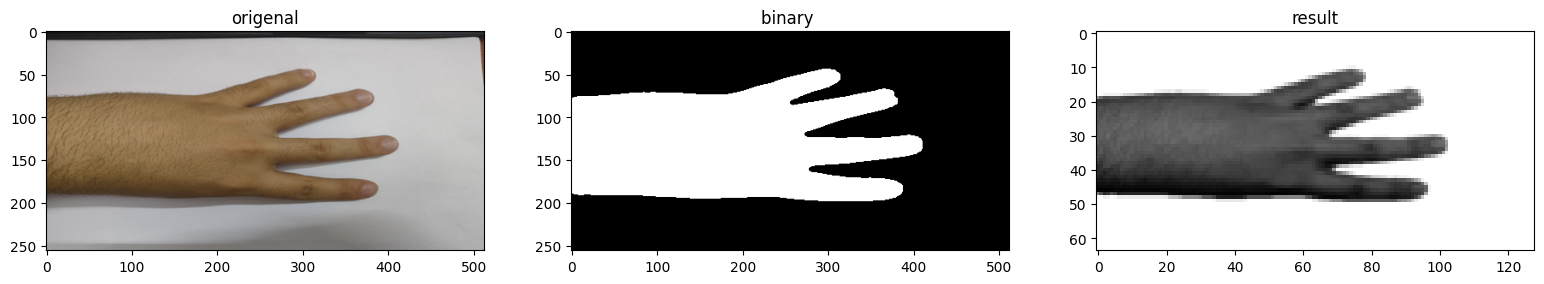

actualy:  2  predected : 1

./test_set_1/


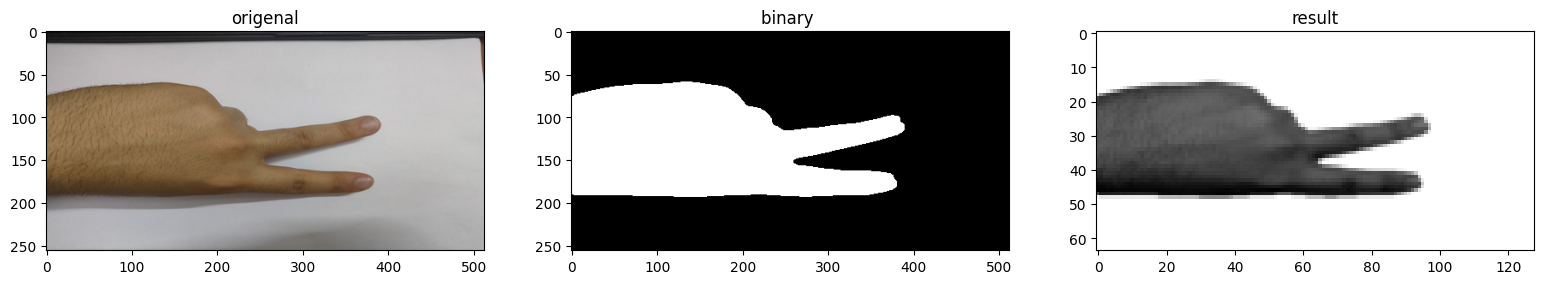

actualy:  2  predected : 1

./test_set_1/


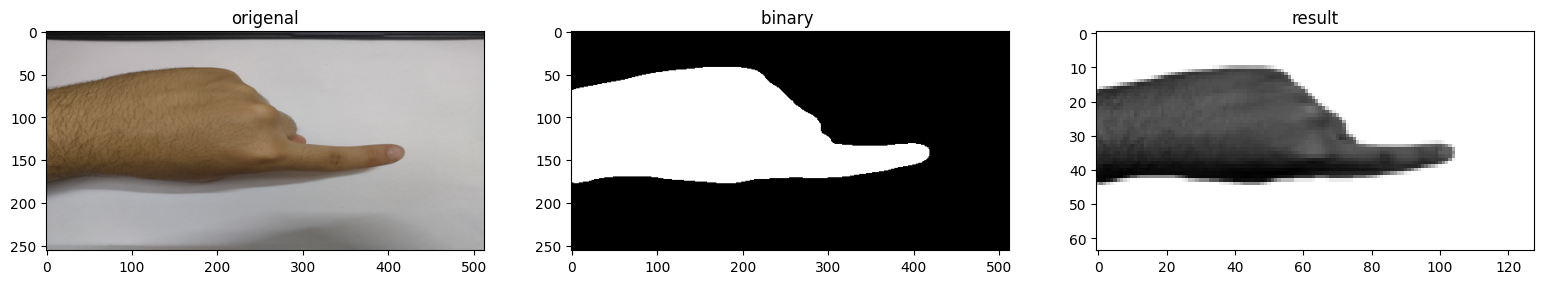

actualy:  2  predected : 1

./test_set_1/


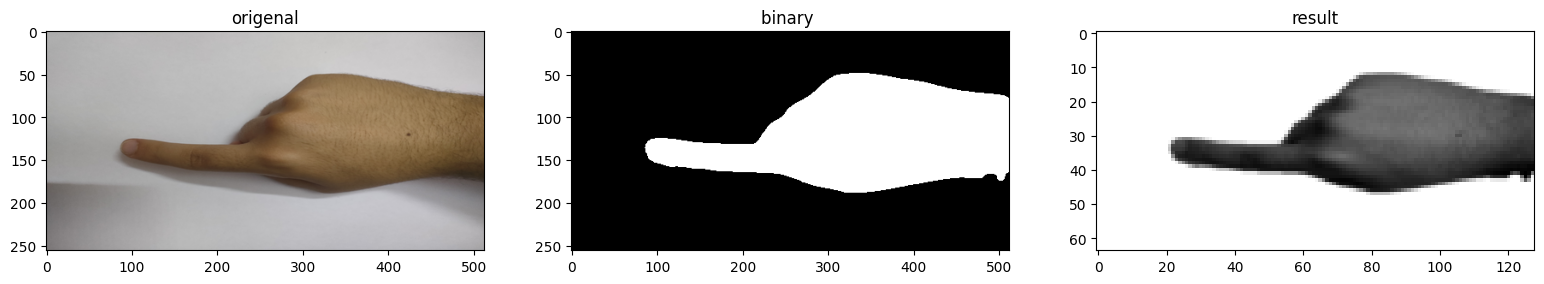

actualy:  2  predected : 1

./test_set_1/


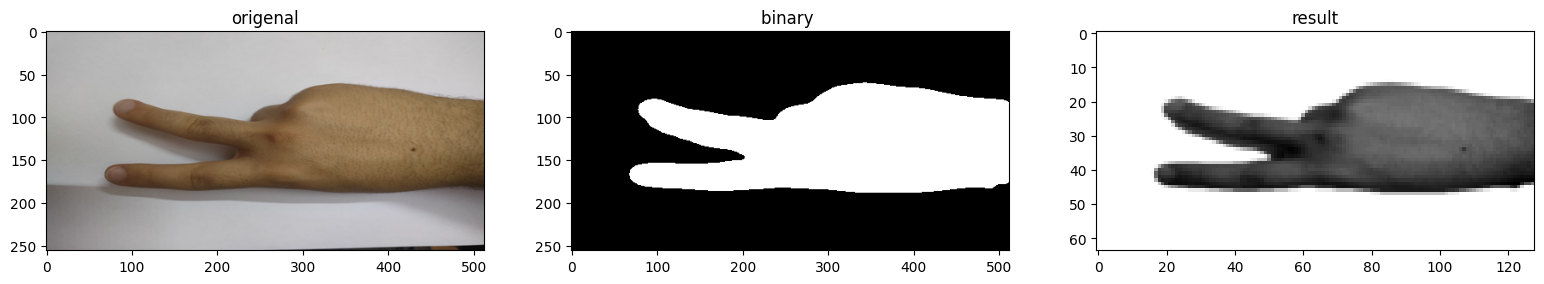

actualy:  2  predected : 1

./test_set_1/


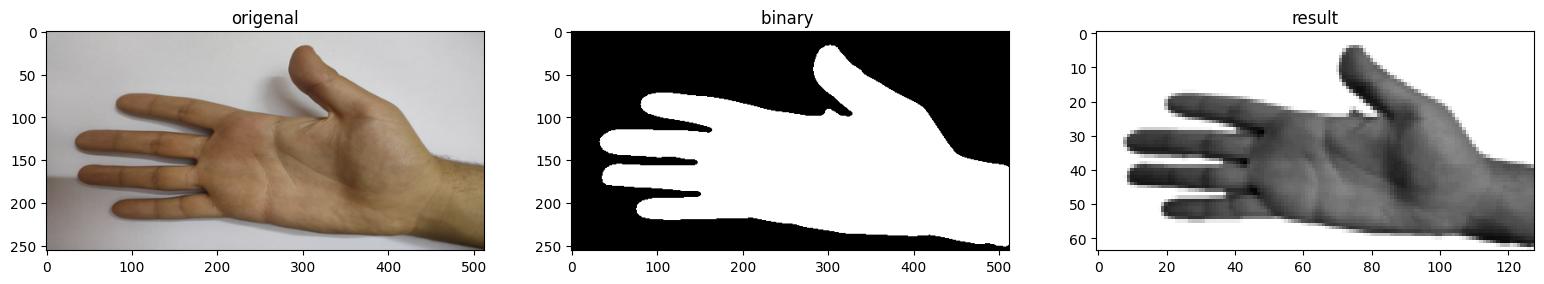

actualy:  2  predected : 1

./test_set_1/


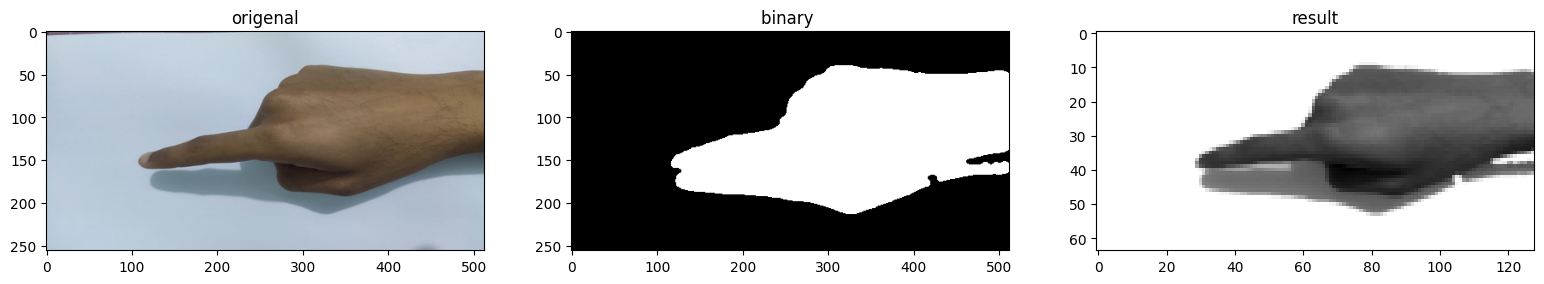

actualy:  2  predected : 1

./test_set_1/


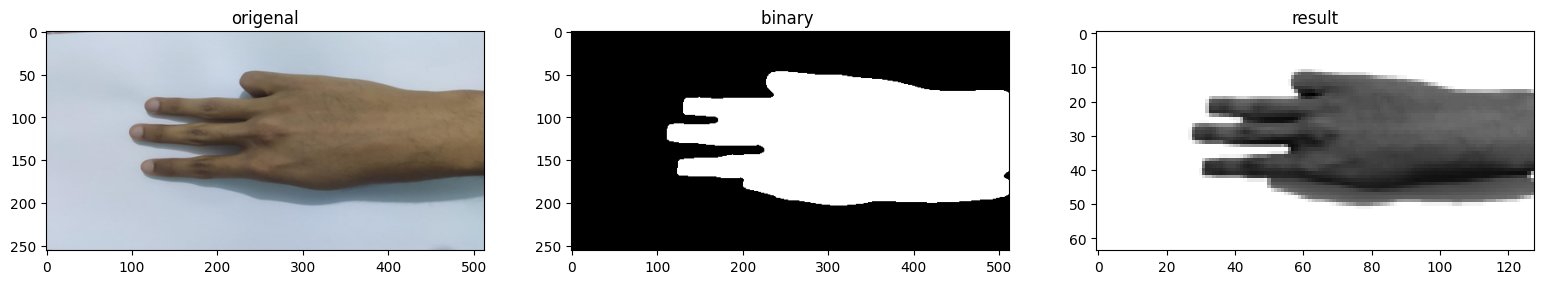

actualy:  2  predected : 1

./test_set_1/


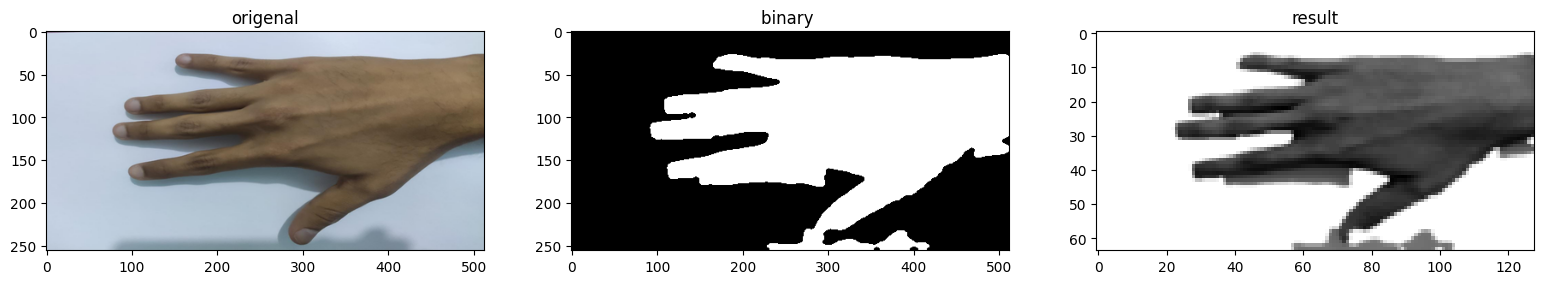

actualy:  2  predected : 1

./test_set_1/


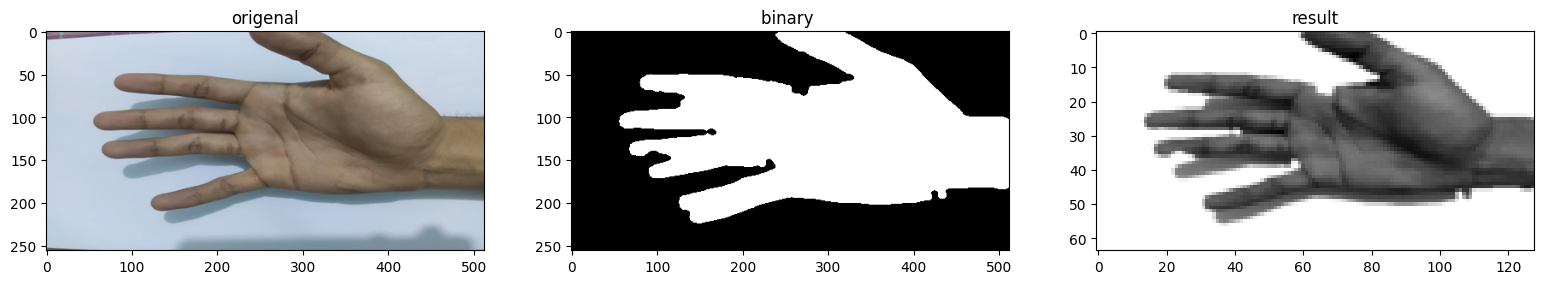

actualy:  2  predected : 1

./test_set_1/


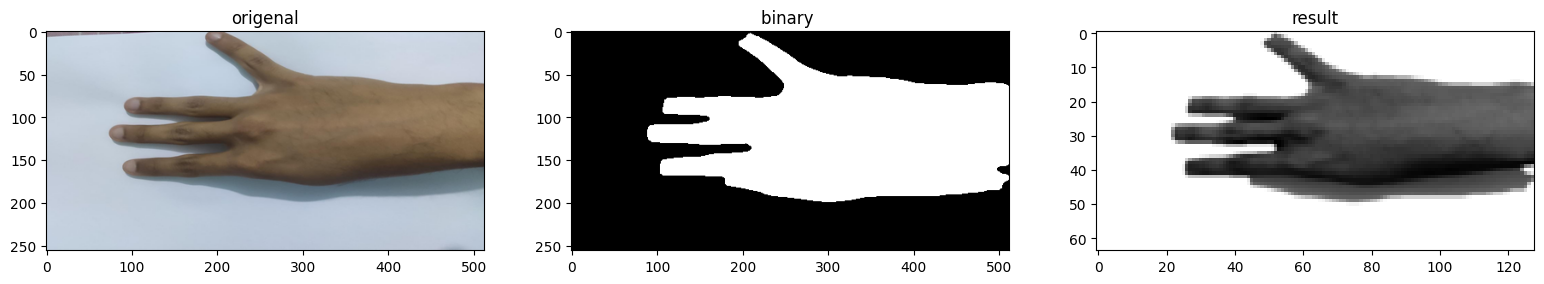

actualy:  2  predected : 1

./test_set_1/


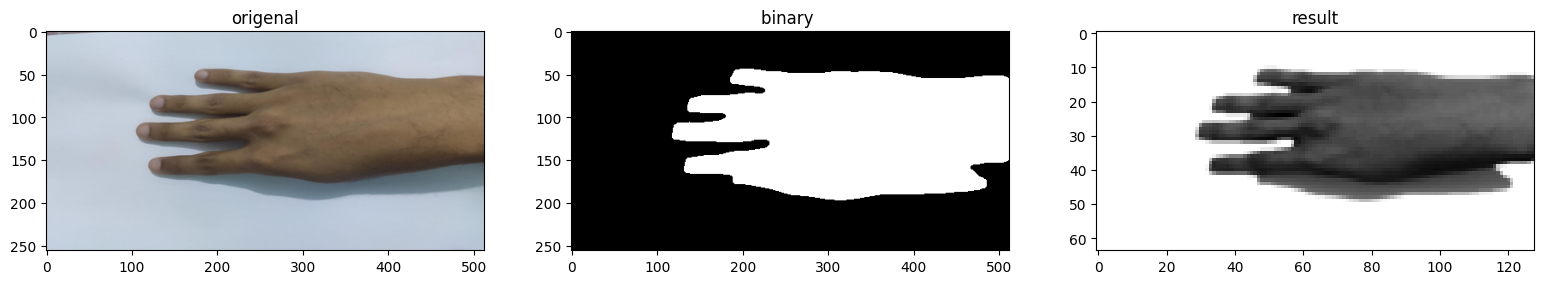

actualy:  2  predected : 1

./test_set_1/


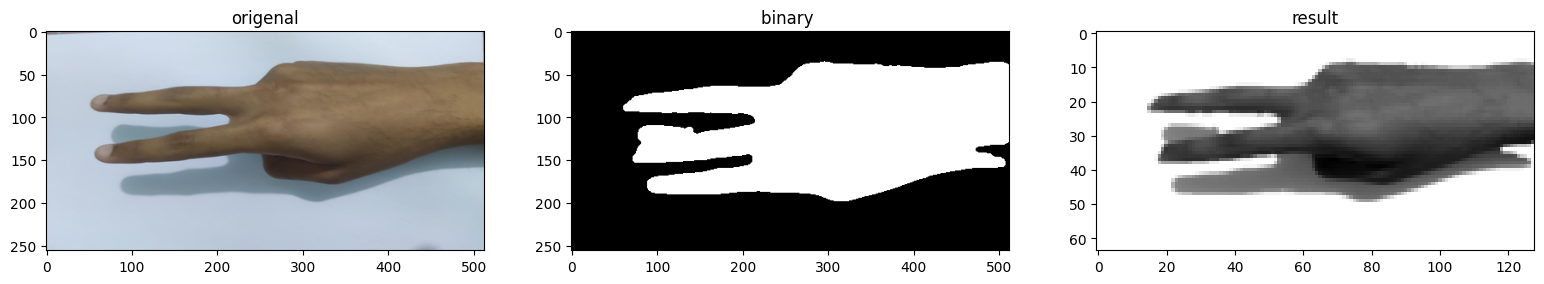

actualy:  2  predected : 1

./test_set_1/


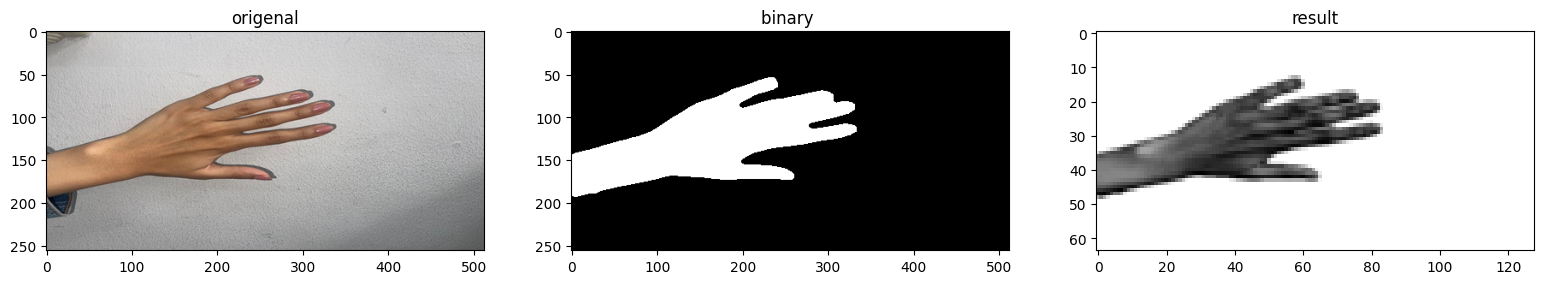

actualy:  2  predected : 1

./test_set_1/


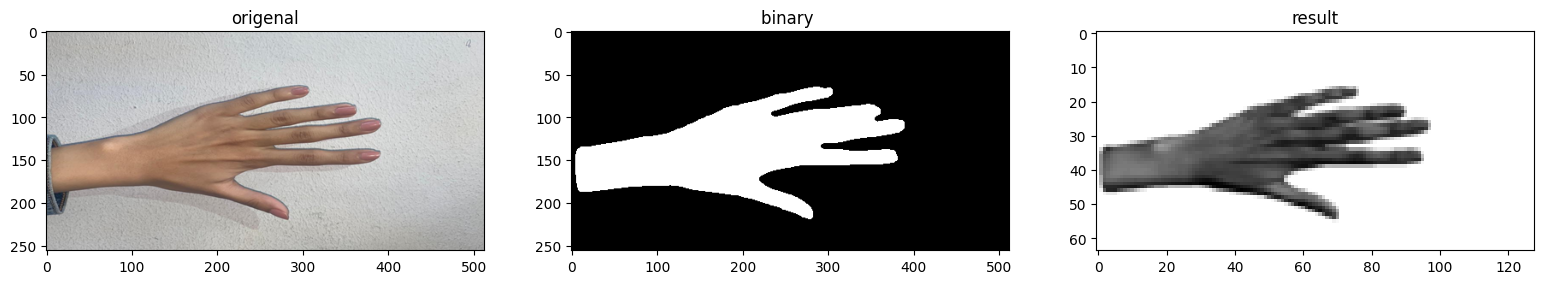

actualy:  2  predected : 1

./test_set_1/


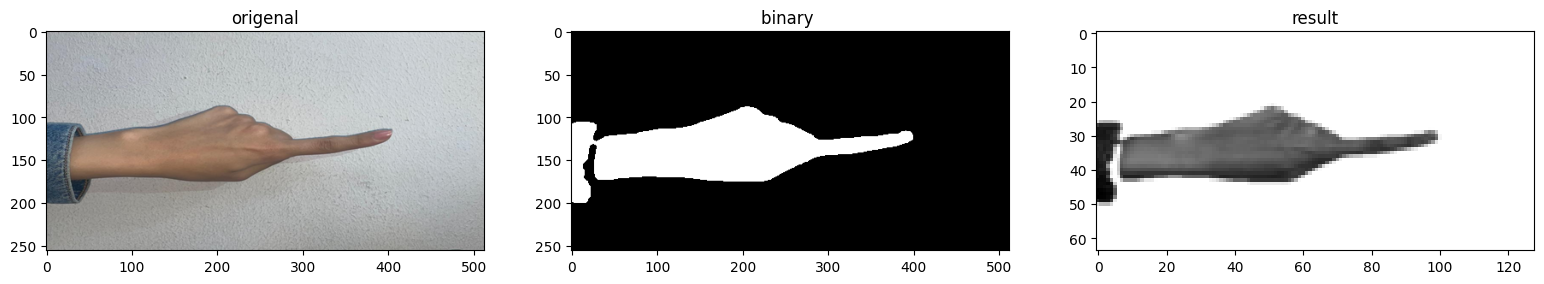

actualy:  2  predected : 1

./test_set_1/


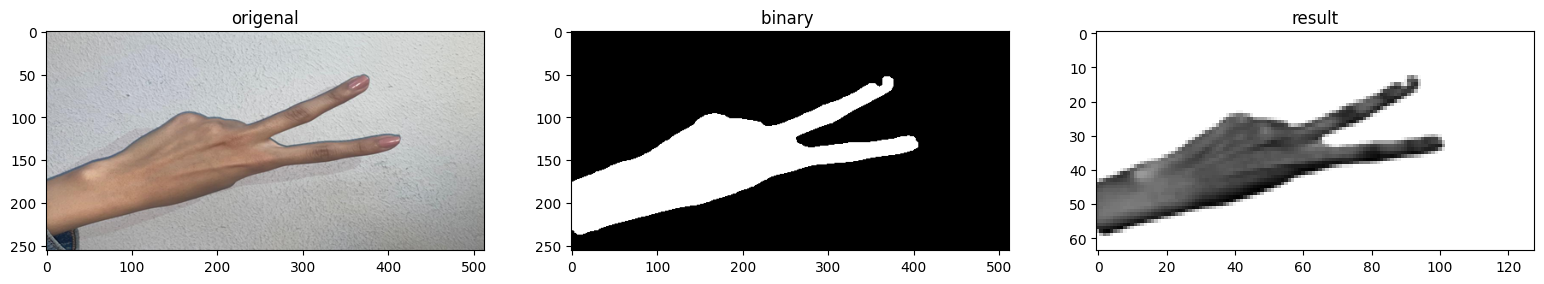

actualy:  2  predected : 1

./test_set_1/


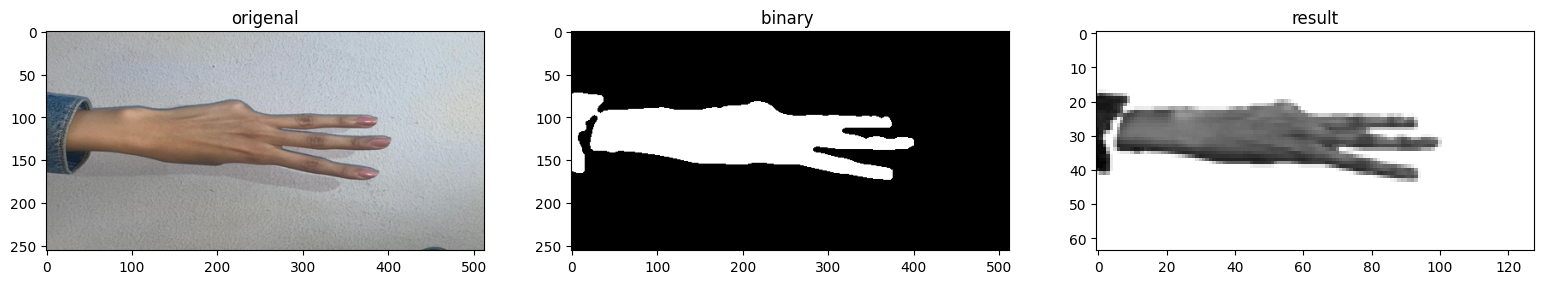

actualy:  2  predected : 1

./test_set_1/


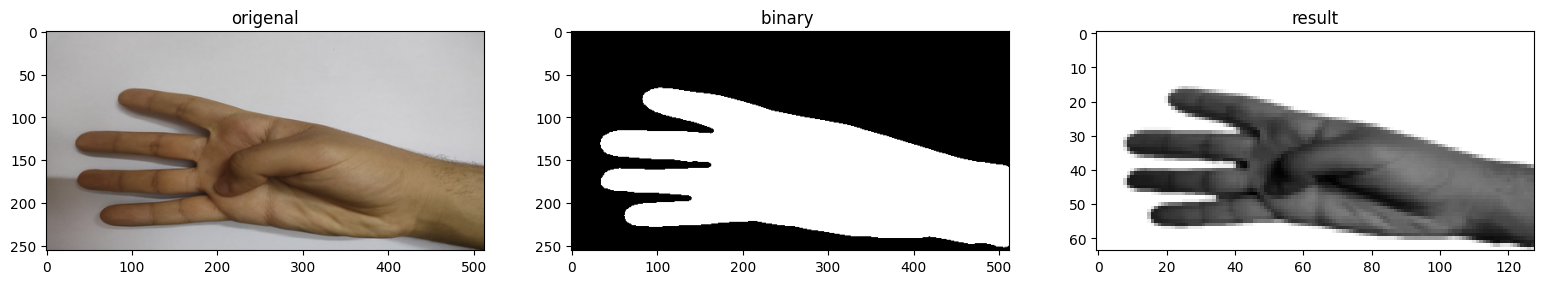

actualy:  2  predected : 1

./test_set_1/


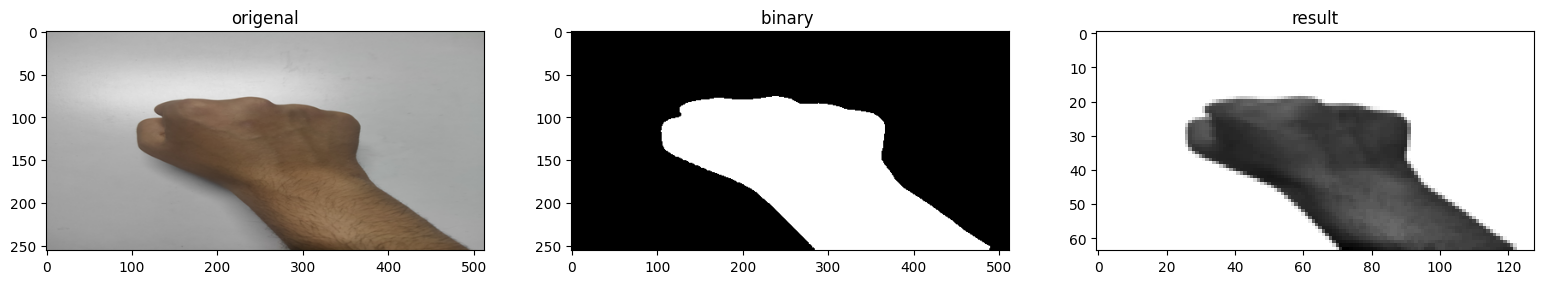

actualy:  2  predected : 1

./test_set_1/


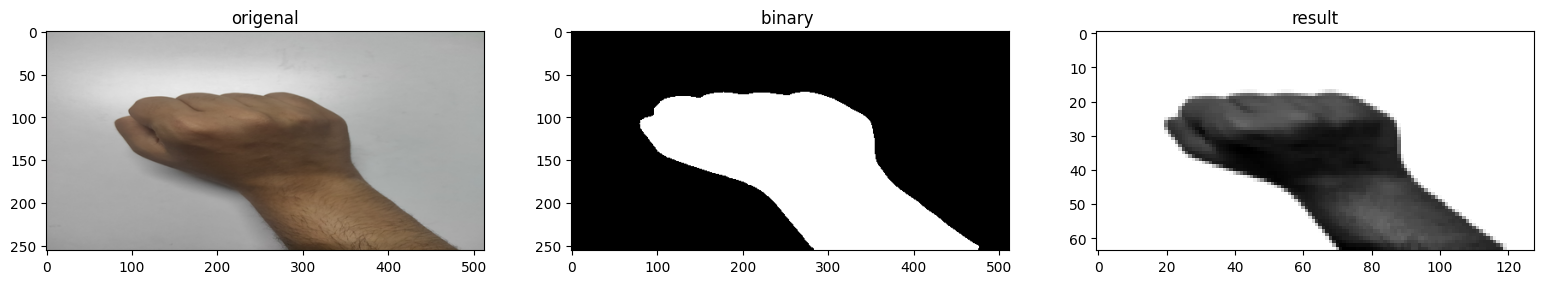

actualy:  2  predected : 1

./test_set_1/


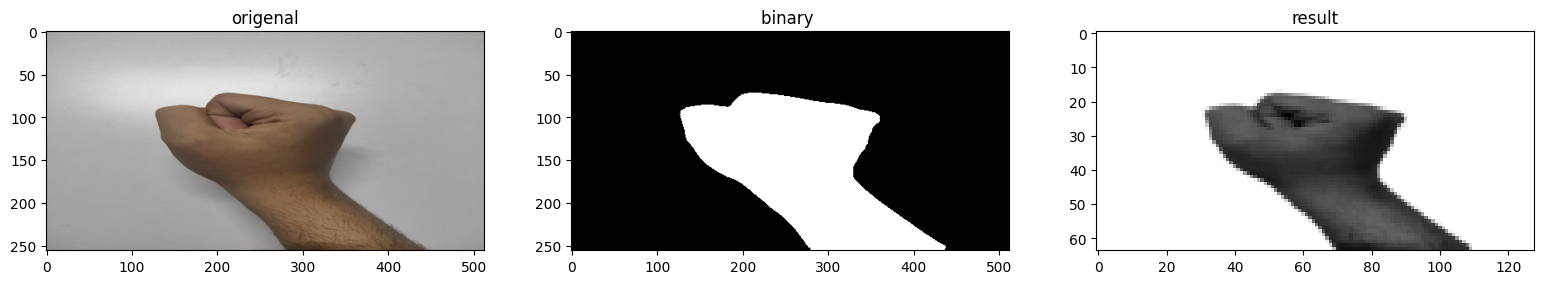

actualy:  2  predected : 1

./test_set_1/


In [6]:
for path, subdirs, files in os.walk('./test_set_1/'):
        # if(path.startswith(directory + '.')):

        for name in files:
            # image=cv2.imread(os.path.join(path, name))

            # image = cv2.imread(os.path.join(path, name), cv2.IMREAD_GRAYSCALE)
            # result=cv2.resize(image, (128, 64)) # multiply by 4

            # pre processing on the image (madbouly)
            pathh = os.path.join(path, name)

            binary, result = image_pre_processing(pathh)
            image = Image.open(pathh)
            image = resize(image, 4 * 128, 4 * 64)
            img_RGB = np.array(image)
            
            show_images([img_RGB, binary, result], ['origenal', 'binary ', 'result'])
            print('actualy: ',actuly,' predected :',pretected)
            print(path)
